# INFO 204 Lab 6 - Pipelines, Cross Validation and Neural Networks (I)


***<span style='color: #ce2227;'>PLEASE READ ALL THE INSTRUCTIONS AND ACCOMPANYING TEXT IN LAB NOTEBOOKS - THE INFORMATION NEDED TO ANSWER A GIVEN TASK OR INTERPRET A GIVEN RESULT IS OFTEN IN THE TEXT!</span>***

In the previous lab, you took the initial steps into using cross validation to identify good hyperparameter and model settings. In this lab, you will:

1. Explore the `Pipeline` functionality of scikit-learn to automate the process of searching for good hyperparameter configurations.
2. Apply the pipeline concept to tuning a neural network.

This lab provides a brief introduction to learning neural network (deep learning) models in scikit-learn. Neural networks are among the most complex methods in machine learning, and require a large amount of hyperparameter tuning to ensure good model fitting. They are also very computationally expensive to fit, typically requiring parallel computing hardware (e.g., GPUs) to obtain good performance in reasonable time. Finally, neural networks work best when there is a large supply of training data. Long story short: we are only able to scratch the surface of neural networks in this lab, and we'll leave the main discussion of them to lectures.

## Precursors

As usual, we will import the libraries that you need for this lab:

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
 
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

from sklearn.datasets import make_friedman1

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

And generate some labelled data for use in the lab:

0            1            2            3            4   \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.009755     0.050618     5.035274     1.479994     4.970736   
std       0.005947     0.028789     2.910888     0.879290     2.890945   
min       0.000009     0.000218     0.000832     0.000682     0.000259   
25%       0.004299     0.025888     2.434592     0.715063     2.422903   
50%       0.009764     0.050867     5.157524     1.433881     4.993854   
75%       0.015133     0.075762     7.528670     2.244486     7.345540   
max       0.019994     0.099773     9.999637     2.998949     9.991937   

                5            6            7            8            9   \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.484161     0.504387     1.505469     1.046937     0.499144   
std       0.285444     0.288774     0.869178     0.577965     0.285236   
min       0.004074     0.002870     0.004172     0.000856     0.000683   
25%       0.235215     0.252513     0.762611     0.548831     0.261932   
50%       0.472277     0.517919     1.521928     1.068265     0.503819   
75%       0.732631     0.756410     2.264244     1.535270     0.746782   
max       0.999395     0.999895     2.996598     1.999773     0.999296   

                10  
count  1000.000000  
mean      0.641023  
std       7.075362  
min     -12.294439  
25%      -6.179361  
50%       0.991210  
75%       7.552964  
max      12.214374

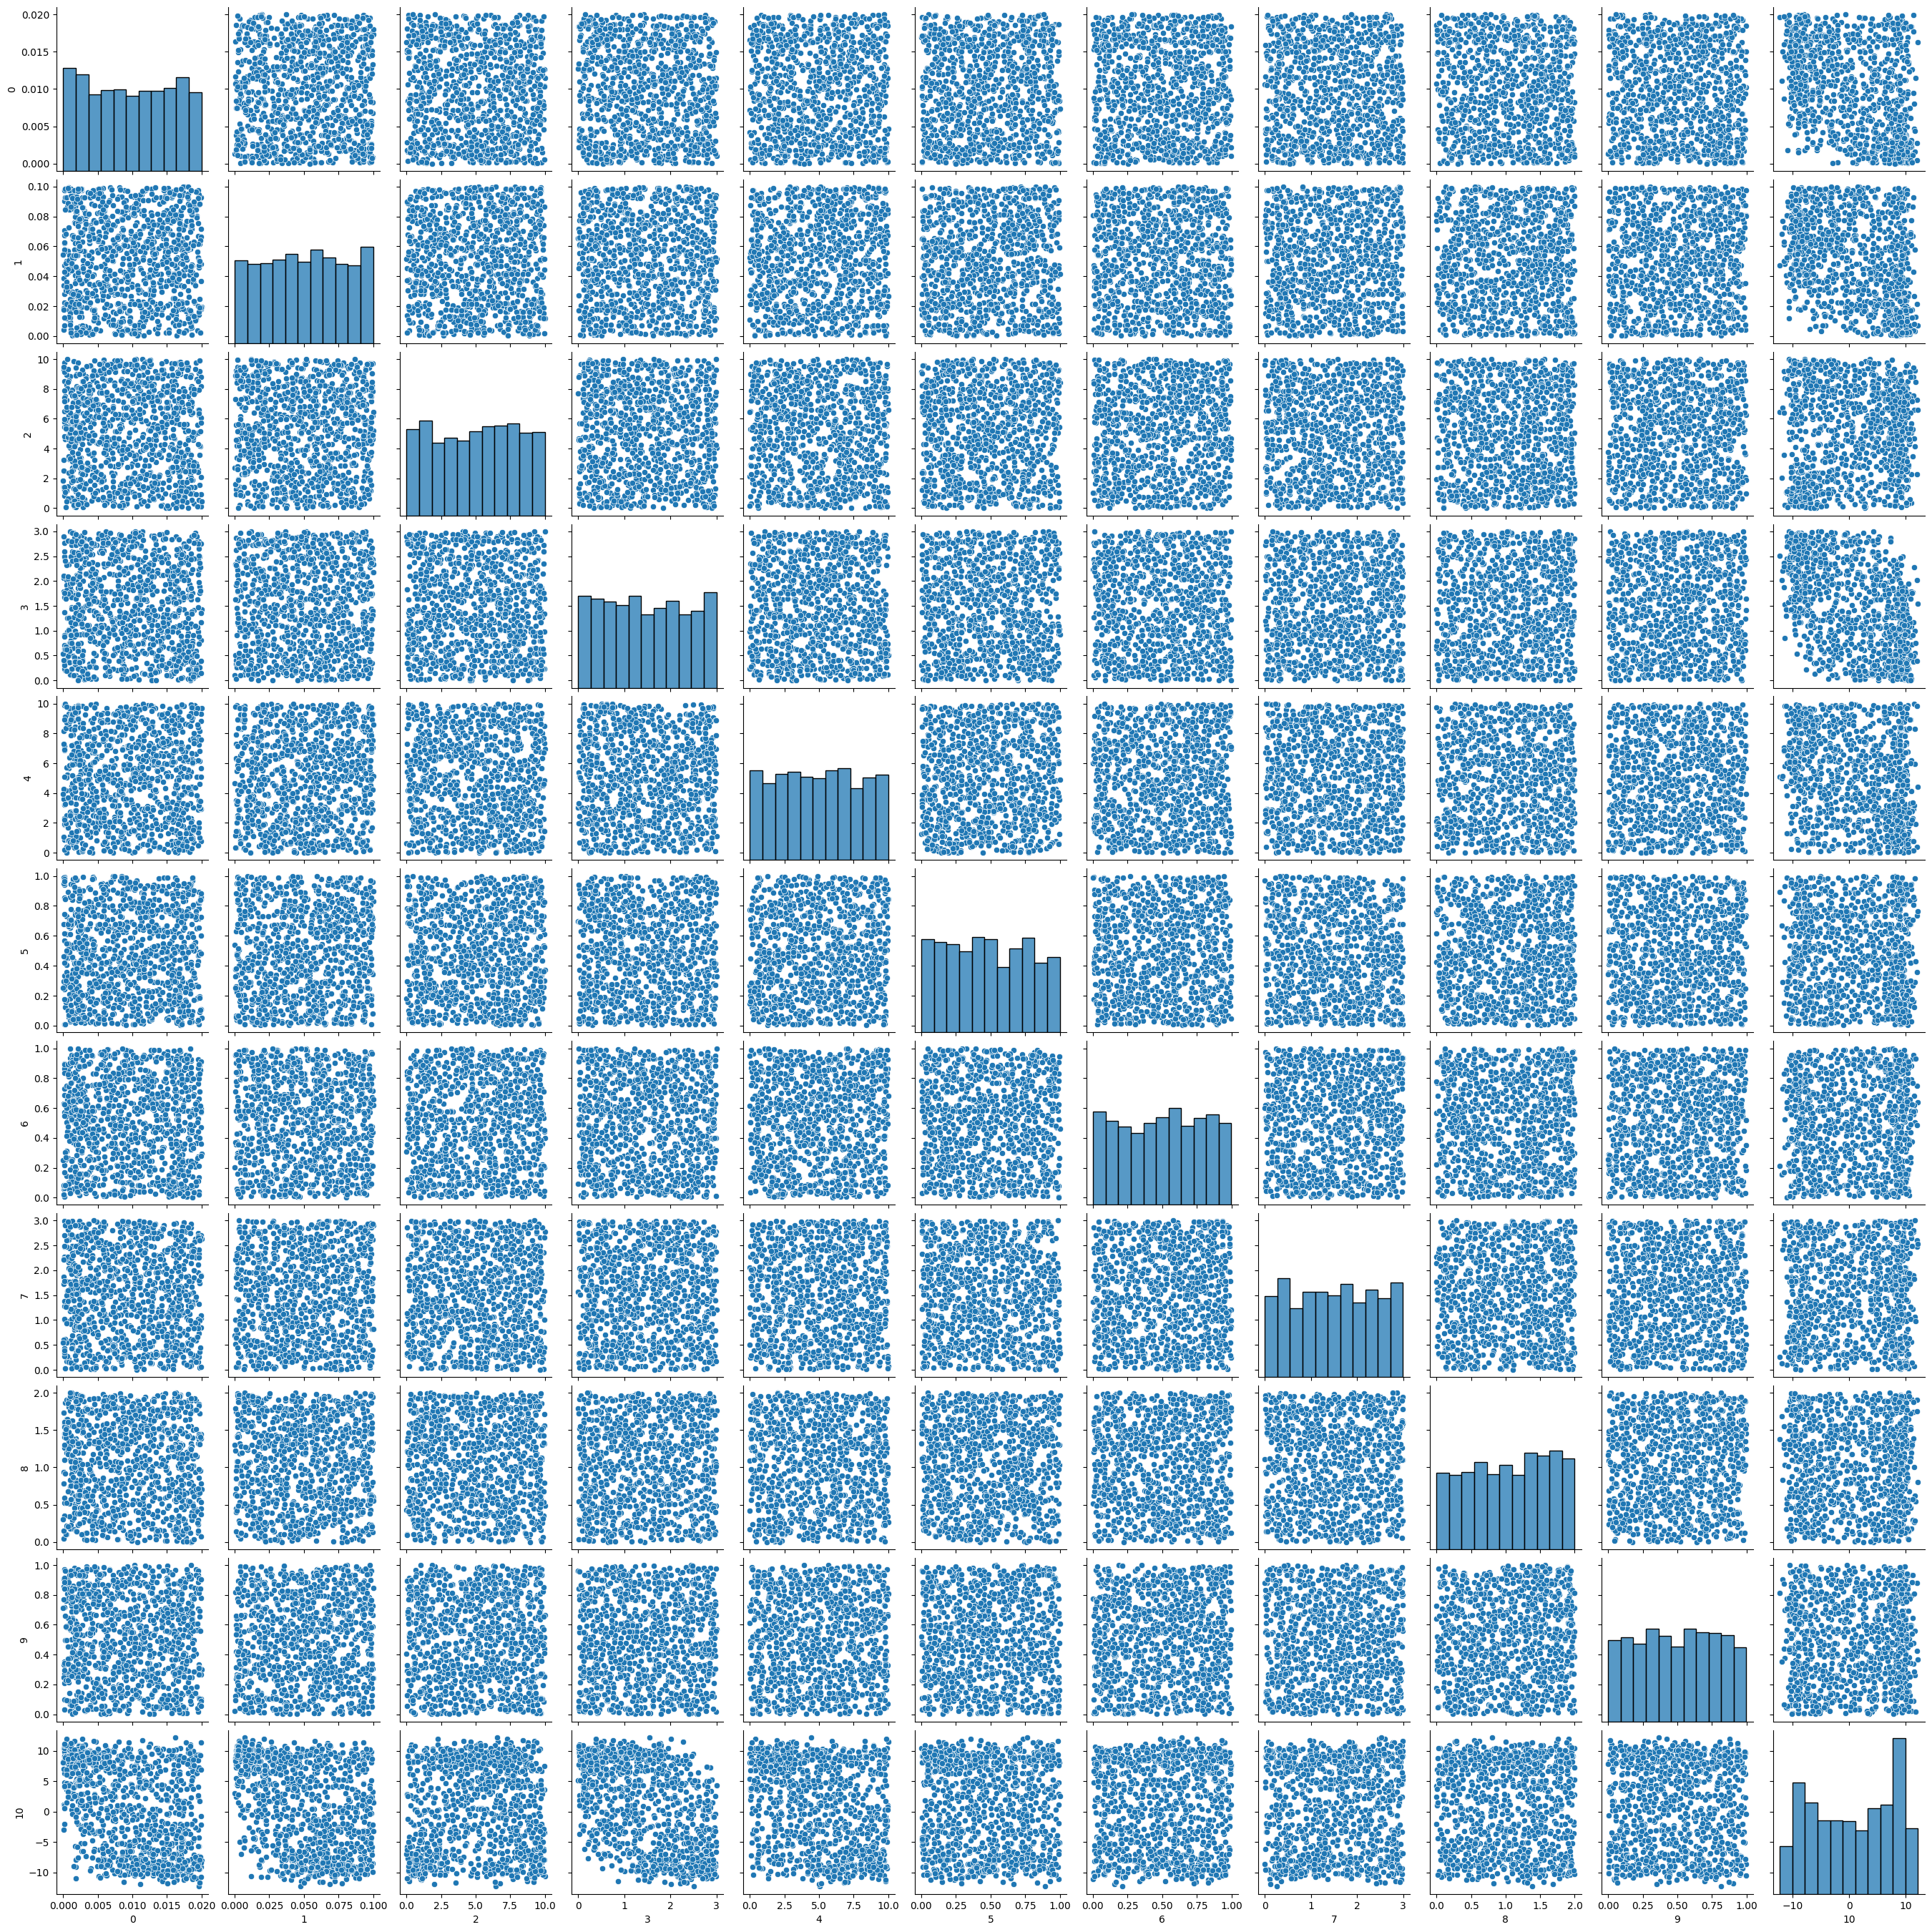

In [54]:
rng = np.random.default_rng(seed=1234)
# X, t = make_friedman1(n_samples=1000, n_features=10, noise=1.0, random_state=1234)
# X *= [ 0.02, 0.1, 10, 3, 10, 1, 1, 3, 2, 1 ]

X, t = make_friedman1(n_samples=1000, n_features=10, noise=0.0, random_state=1234)
X *= [ 0.02, 0.1, 10, 3, 10, 1, 1, 3, 2, 1 ]
l, u = t.min(), t.max()
t = 10 * np.sin(2 * np.pi * (t - l) / (u - l)) + rng.normal(0, 1, size=len(t))

all_data = pd.DataFrame(np.hstack((X, t.reshape(-1, 1))))
display(all_data.describe())
sns.pairplot(all_data)

And finally, we will use cross validation in this lab, so let's set up the required folds (10 folds in this case):

In [55]:
folds = KFold(n_splits=10, shuffle=True, random_state=1234)

## Pipeline basics

In [56]:
ml_pipe = Pipeline([ ('scale', 'passthrough'), ('model', DummyRegressor()) ])

The `ml_pipe` pipline has now set up two named stages in the machine learning process - a preprocessing stage named "scale" and a modelling stage named "model". The "scale" stage allows us to plug in a transformer (e.g., `StandardScaler`) to process the supplied features, while the "model" stage allows us to plug in a suitable estimator (e.g., `LinearRegression` or `KNearestRegressor`). The default configuration of this pipeline is to perform no preprocessing (as indicated by the string `'passthrough'`) followed by a dummy regressor. We expect this to perform poorly, but we can easily plug and test in new components as needed.

The pipeline can now be used like an estimator as used in previous labs. We can call `fit()` or `predict()` on it, like any other model that we have built. Or, we can use it within the "model selection" frameworks that scikit-learn provides. For example, to perform 10-fold cross validation on the pipeline, we can use the `cross_val_score()` function:

In [57]:
cross_val_score(ml_pipe, X, t, cv=folds, n_jobs=-1).mean()

-0.01691763725608144

As expected, the pipeline in its default configuration has a dummy regressor that performs poorly. We can replace the dummy regressor with a more informed model by specifying a dictionary of tuning parameters. For example, to insert linear regression in at the "model" stage of the pipeline, we could perform the following:

In [58]:
lm_tune_grid = {
    'model' : LinearRegression()
}
ml_pipe.set_params(**lm_tune_grid)

cross_val_score(ml_pipe, X, t, cv=folds, n_jobs=-1).mean()

0.5721895077691614

Again, as expected, this pipeline now performs much better.

More elaborate configuration of the pipeline can be completed by supplying more details in the tuning dictionary. For example, to insert standardisation in the "scale" stage, and a 20-neighbourhood kNN in the "model" step, we would perform the following:

In [59]:
knn_tune_grid = {
    'scale' : StandardScaler(),
    'model' : KNeighborsRegressor(),
    'model__n_neighbors' : 20
}
ml_pipe.set_params(**knn_tune_grid)

cross_val_score(ml_pipe, X, t, cv=folds, n_jobs=-1).mean()

0.6018070714613403

Notice the use of the double underscore approach to specify the hyperparameter for the estimator used in the "model" stage. Scikit-learn uses this pattern of `<stage name>__<hyperparameter name>` to create hierarchies of parameters.

**<span style="color: #ce2227;">TASK 1: </span>** Why do you think scikit-learn has adopted this `<stage name>__<hyperparameter name>` pattern of specifying hyperparameters?

It makes it a lot easier to see and distinguish hyperparameters and show hierarchies very clearly. It makes it easier to associate the hyperparamter with a specific step/model.

**<span style="color: #ce2227;">TASK 2: </span>** Configure the pipeline to use a CART decision tree (`DecisionTreeRegressor`) in the model stage with a `min_samples_split` hyperparameter of 40. Ensure that the pipeline does _NOT_ use standardisation. Then use `cross_val_score()` to measure the performance of the resulting pipeline.

In [60]:
knn_tune_grid = {
    'scale' : StandardScaler(),
    'model' : DecisionTreeRegressor(),
    'model__min_samples_split' : 40
}
ml_pipe.set_params(**knn_tune_grid)

cross_val_score(ml_pipe, X, t, cv=folds, n_jobs=-1).mean()

0.5993136344476355

### Hyperparameter Analyis in Pipelines

Now that we have the basics of setting up a pipeline covered, we can move to the concept of exploring pipeline hyperparameters using a `GridSearchCV` object. This process starts in a similar manner to before - set up a dictionary of tuning parameters (however, a list of values now, rather than a scalar). Then, instead of using `cross_val_score` we pass the resulting details into an instance of a `GridSearchCV` object.

Because we may need to reference them later (e.g., to fetch and analyse results), we should start by defining the transformers, estimators and other details that will be used in the experiment:

In [61]:
scale = StandardScaler()
knn = KNeighborsRegressor()

all_k = np.unique(np.logspace(0, 2, 20, base=10).astype(int)) ## logspace determines a logarithmically-spaced series of points between a specified lower and upper bound
print(f"Using the neighbourhood sizes: {all_k}")

Using the neighbourhood sizes: [  1   2   3   4   5   6   8  11  14  18  23  29  37  48  61  78 100]


Then, we set up the tuning grid, just as before. However, as we are exploring multiple possible values in each stage, each configuration point should be placed in a list (even if there's only one value being explored for a given hyperparameter). In this case, we're going to explore kNN with and without standardisation, over a range of neighbourhood sizes:

In [62]:
knn_tune_grid = {
    'scale' : [ 'passthrough', scale ],
    'model' : [ knn ],
    'model__n_neighbors' : all_k
}

The tuning grid now defines a "search space" of possible hyperparameter combinations. In this case, there are 2x1x17 possible hyperparameter combinations in the search space.

As discussed in Lecture 10, we could write code to iterate over these combinations one-by-one and perform cross validation on each combination. Or, to reduce the amount of repetitive code that we need, we can use a `GridSearchCV` object that captures all of this for us, and returns a collection of data describing the cross validation process for us to analyse. To do this, we instantiate a `GridSearchCV` object, and then call its `fit()` member function, passing in our data:

In [63]:
cv = GridSearchCV(ml_pipe, knn_tune_grid, cv=folds, n_jobs=-1)
cv.fit(X, t)
print(cv.best_params_, cv.best_score_)

{'model': KNeighborsRegressor(n_neighbors=8), 'model__n_neighbors': 8, 'scale': StandardScaler()} 0.6265371735825547


Notice that cross validation has selected a standardised variant of kNN with a neighbourhood size of 8.

Together, the entire block of code to run cross validation analysis of the hyperparameters of a pipeline is as follows:

In [64]:
scale = StandardScaler()
knn = KNeighborsRegressor()

all_k = np.unique(np.logspace(0, 2, 20, base=10).astype(int))

knn_tune_grid = {
    'scale' : [ 'passthrough', scale ],
    'model' : [ knn ],
    'model__n_neighbors' : all_k
}

cv = GridSearchCV(ml_pipe, knn_tune_grid, cv=folds, n_jobs=-1)
cv.fit(X, t)
print(cv.best_params_, cv.best_score_)

{'model': KNeighborsRegressor(n_neighbors=8), 'model__n_neighbors': 8, 'scale': StandardScaler()} 0.6265371735825547


The `GridSearchCV` object, once `fit()` has been called, contains a dictionary of results called `cv_results_`. This can be turned into a data frame for easier analysis:

In [65]:
perf = pd.DataFrame(cv.cv_results_)
perf.head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.002093      0.000537         0.001396        0.000661   
1       0.002492      0.000919         0.002392        0.000488   
2       0.001694      0.000457         0.001794        0.000399   
3       0.002192      0.000399         0.002491        0.000498   
4       0.001894      0.000299         0.001395        0.000661   

                          param_model param_model__n_neighbors  \
0  KNeighborsRegressor(n_neighbors=8)                        1   
1  KNeighborsRegressor(n_neighbors=8)                        1   
2  KNeighborsRegressor(n_neighbors=8)                        2   
3  KNeighborsRegressor(n_neighbors=8)                        2   
4  KNeighborsRegressor(n_neighbors=8)                        3   

        param_scale                                             params  \
0       passthrough  {'model': KNeighborsRegressor(n_neighbors=8), ...   
1  StandardScaler()  {'model': KNeighborsRegressor(n_neighbors=8), ...   
2       passthrough  {'model': KNeighborsRegressor(n_neighbors=8), ...   
3  StandardScaler()  {'model': KNeighborsRegressor(n_neighbors=8), ...   
4       passthrough  {'model': KNeighborsRegressor(n_neighbors=8), ...   

   split0_test_score  split1_test_score  ...  split3_test_score  \
0          -0.189634          -0.500827  ...           0.016482   
1           0.344908           0.243865  ...           0.399214   
2           0.023347          -0.154477  ...           0.225403   
3           0.488286           0.508068  ...           0.499215   
4           0.091363           0.023247  ...           0.226578   

   split4_test_score  split5_test_score  split6_test_score  split7_test_score  \
0          -0.597365          -0.341686          -0.464431          -0.295001   
1           0.109798           0.335833           0.283398           0.131673   
2           0.054263           0.085928          -0.008116          -0.121448   
3           0.422800           0.453632           0.478661           0.503753   
4           0.231849           0.195586           0.116710          -0.024792   

   split8_test_score  split9_test_score  mean_test_score  std_test_score  \
0          -0.248298          -0.179094        -0.274231        0.202086   
1           0.022609           0.451994         0.265986        0.130728   
2           0.079024           0.169804         0.046170        0.112151   
3           0.358222           0.515639         0.478608        0.052813   
4           0.123563           0.334424         0.153267        0.102238   

   rank_test_score  
0               34  
1               26  
2               33  
3               15  
4               32  

[5 rows x 21 columns]

Inspect the names of the resulting data frame before continuing. Notice that anything defined in the tuning grid is prefixed with `param_` in the data frame. Later on in this lab, we will present a small function to process these column names to make them easier to work with.

The resulting data frame, called `perf` here, can be used for plotting analysis. For example to analyse the effect of standardisation and neighbourhood size on kNN, we can plot the following:

<AxesSubplot:xlabel='param_model__n_neighbors', ylabel='mean_test_score'>

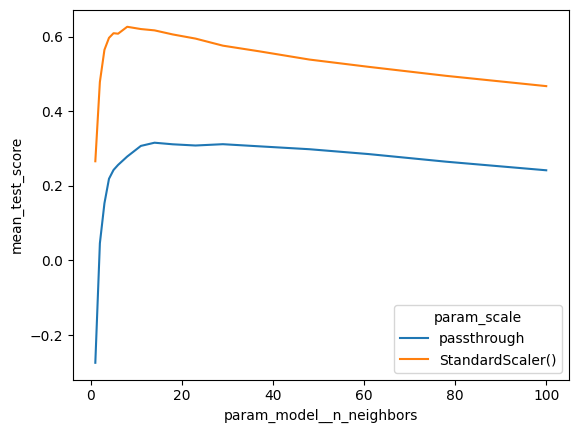

In [66]:
sns.lineplot(data=perf, x='param_model__n_neighbors', y='mean_test_score', hue='param_scale')

**<span style="color: #ce2227;">TASK 3: </span>** perform a hyperparameter analysis of the pipeline using a CART decision tree, _WITHOUT_ standardisation, and exploring a reasonable number of values for `min_samples_split` (e.g., 20 logarithmically-spaced values from 2 to 500). Plot the result as a lineplot.

{'model': DecisionTreeRegressor(min_samples_split=37), 'model__min_samples_split': 37, 'scale': 'passthrough'} 0.6008642283932473


<AxesSubplot:xlabel='param_model__min_samples_split', ylabel='mean_test_score'>

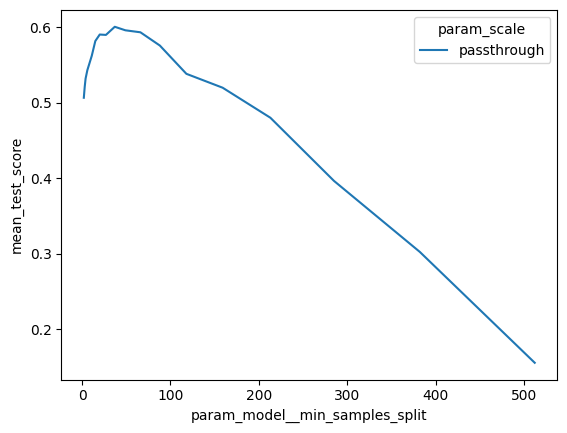

In [67]:
cart = DecisionTreeRegressor()

all_split = np.unique(np.logspace(1, 9, 20, base=2).astype(int))
cart_tune_grid = {
    'scale' : [ 'passthrough'],
    'model' : [ cart ],
    'model__min_samples_split' : all_split
}

cv = GridSearchCV(ml_pipe, cart_tune_grid, cv=folds, n_jobs=-1)
cv.fit(X, t)
print(cv.best_params_, cv.best_score_)

perf = pd.DataFrame(cv.cv_results_)
perf.head(5)
sns.lineplot(data=perf, x='param_model__min_samples_split', y='mean_test_score', hue='param_scale')

### Cleaning Up the CV Results Data Frame

The `cv_results_` collection contains a lot of information, but there may be cases where the information is not presented in the most useful way. For example, the resulting data frame is in wide format, which is not ideal for plotting and other types of analysis. Also, the column names of the data frame are quite verbose and cumbersome to use. However, we can clean up both of these issues fairly easily with the following function:

In [68]:
def cleanup_cv_results(cv_results, model_name='model', scale_name='scale'):
    import re
    
    ## remove the "param_"  and "param_model__" prefixes from columns
    r = re.compile(f"param_({model_name}__)*")
    cleaned_names = cv_results.rename(columns=lambda x: r.sub('', x))

    ## identify all the columns that are not the per-split cross validation scores
    r = re.compile(f"split.+_test_score")
    header_cols = [ c for c in cleaned_names.columns.values if not r.match(c) ]
    
    ## return the long version of the data
    return cleaned_names.melt(id_vars=header_cols, var_name='split', value_name='score')


Using this function is easy - simply pass it the data frame:

In [71]:
cv = GridSearchCV(ml_pipe, knn_tune_grid, cv=folds, n_jobs=-1)
cv.fit(X, t)
perf = pd.DataFrame(cv.cv_results_)

perf = cleanup_cv_results(perf)
perf.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.001694      0.000457         0.001296        0.000638   
1       0.002292      0.000457         0.002093        0.000299   
2       0.001395      0.000488         0.001395        0.000488   
3       0.001993      0.000446         0.002492        0.000499   
4       0.001894      0.000299         0.001495        0.000669   
5       0.002492      0.000919         0.004086        0.002378   
6       0.001694      0.000638         0.002193        0.001073   
7       0.003888      0.004309         0.004186        0.003957   
8       0.001594      0.000488         0.001595        0.000488   
9       0.002093      0.000299         0.002890        0.001132   

                                model n_neighbors             scale  \
0  KNeighborsRegressor(n_neighbors=8)           1       passthrough   
1  KNeighborsRegressor(n_neighbors=8)           1  StandardScaler()   
2  KNeighborsRegressor(n_neighbors=8)           2       passthrough   
3  KNeighborsRegressor(n_neighbors=8)           2  StandardScaler()   
4  KNeighborsRegressor(n_neighbors=8)           3       passthrough   
5  KNeighborsRegressor(n_neighbors=8)           3  StandardScaler()   
6  KNeighborsRegressor(n_neighbors=8)           4       passthrough   
7  KNeighborsRegressor(n_neighbors=8)           4  StandardScaler()   
8  KNeighborsRegressor(n_neighbors=8)           5       passthrough   
9  KNeighborsRegressor(n_neighbors=8)           5  StandardScaler()   

                                              params  mean_test_score  \
0  {'model': KNeighborsRegressor(n_neighbors=8), ...        -0.274231   
1  {'model': KNeighborsRegressor(n_neighbors=8), ...         0.265986   
2  {'model': KNeighborsRegressor(n_neighbors=8), ...         0.046170   
3  {'model': KNeighborsRegressor(n_neighbors=8), ...         0.478608   
4  {'model': KNeighborsRegressor(n_neighbors=8), ...         0.153267   
5  {'model': KNeighborsRegressor(n_neighbors=8), ...         0.564748   
6  {'model': KNeighborsRegressor(n_neighbors=8), ...         0.219043   
7  {'model': KNeighborsRegressor(n_neighbors=8), ...         0.596806   
8  {'model': KNeighborsRegressor(n_neighbors=8), ...         0.242712   
9  {'model': KNeighborsRegressor(n_neighbors=8), ...         0.609322   

   std_test_score  rank_test_score              split     score  
0        0.202086               34  split0_test_score -0.189634  
1        0.130728               26  split0_test_score  0.344908  
2        0.112151               33  split0_test_score  0.023347  
3        0.052813               15  split0_test_score  0.488286  
4        0.102238               32  split0_test_score  0.091363  
5        0.027071               10  split0_test_score  0.579867  
6        0.090830               31  split0_test_score  0.166700  
7        0.035866                7  split0_test_score  0.649691  
8        0.074751               29  split0_test_score  0.198223  
9        0.029851                4  split0_test_score  0.665320

And now, we can use the cleaned up data frame for plotting (note how this time, because the data is in long format, we get a confidence interval on the plots):

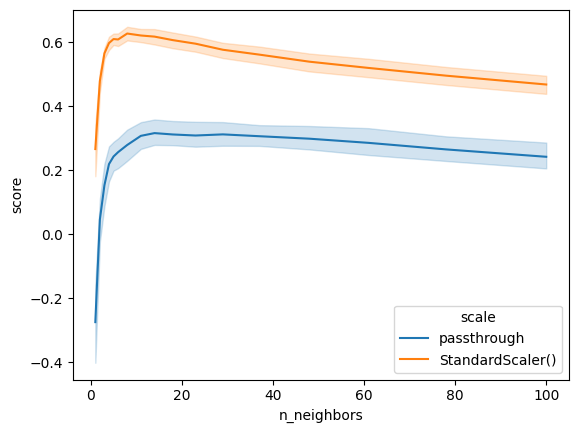

In [72]:
sns.lineplot(data=perf, x='n_neighbors', y='score', hue='scale');

### Analysing multiple estimators

So far, we have examined single estimators within the pipeline. To perform a comparison across estimators, we need to set up a list of tuning dictionaries (one for each method). Beyond that, the approach is unchanged. For example, to compare linear regression and kNN within our pipeline, we could do the following:

In [73]:
scale = StandardScaler()
lm = LinearRegression()
knn = KNeighborsRegressor()

all_k = np.unique(np.logspace(0, 2, 20, base=10).astype(int))

lm_tune_grid = {
    'scale' : [ 'passthrough' ],
    'model' : [ lm ]
}

knn_tune_grid = {
    'scale' : [ 'passthrough', scale ],
    'model' : [ knn ],
    'model__n_neighbors' : all_k
}

cmp_tune_grid = [
    lm_tune_grid,
    knn_tune_grid
]

cv = GridSearchCV(ml_pipe, cmp_tune_grid, cv=folds, n_jobs=-1)
cv.fit(X, t)
print(cv.best_params_, cv.best_score_)

{'model': KNeighborsRegressor(n_neighbors=8), 'model__n_neighbors': 8, 'scale': StandardScaler()} 0.6265371735825547


Now, the data frame resulting from cross validation will contain all the results from both linear regression and kNN. For example, to compare the results, we could plot as follows:

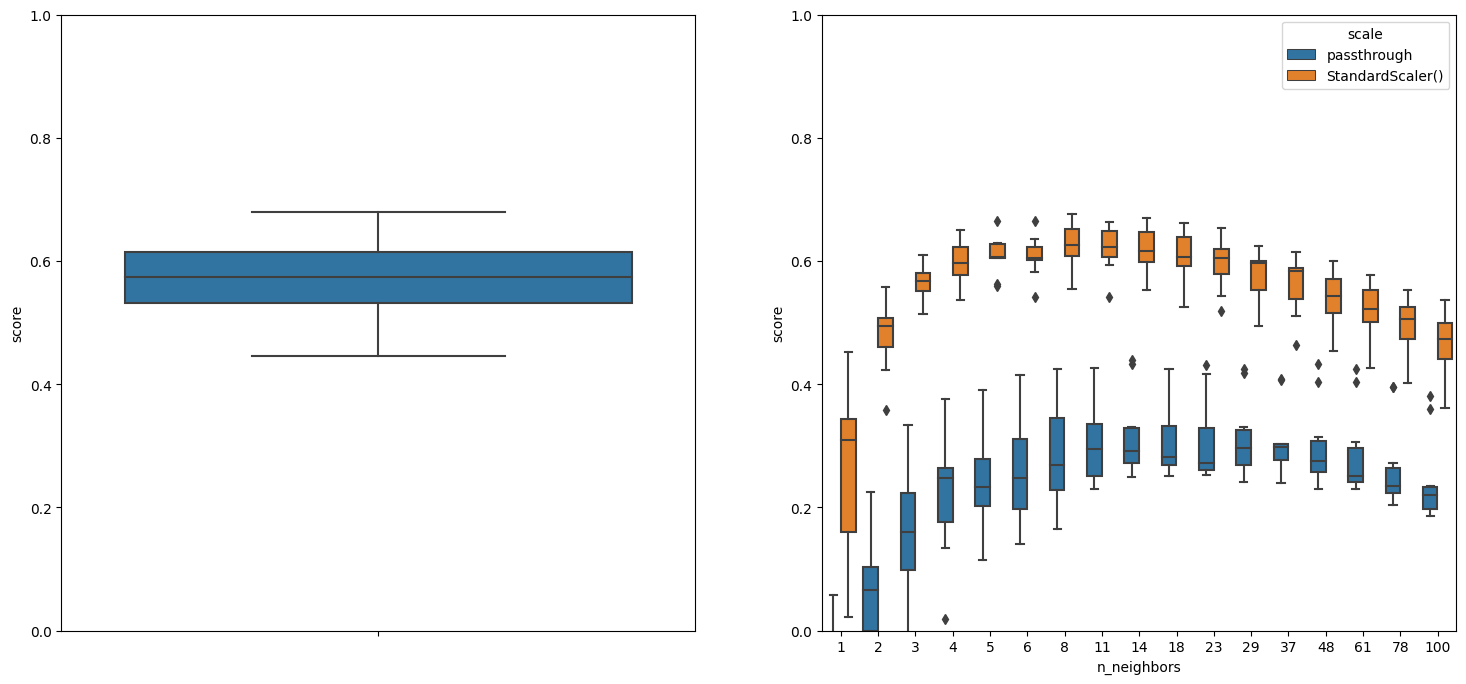

In [74]:
clean = cleanup_cv_results(pd.DataFrame(cv.cv_results_))

fig, axs = plt.subplots(1, 2, figsize=(18, 8))
sns.boxplot(data=clean[clean['model']==lm], y='score', ax=axs[0])
sns.boxplot(data=clean[clean['model']==knn], x='n_neighbors', y='score', hue='scale', ax=axs[1])
axs[0].set(ylim=(0, 1))
axs[1].set(ylim=(0, 1))
plt.show()

## Neural Networks

Neural networks and deep learning were introduced in Lecture 11. Complete analysis of neural networks requires an entire course, so we'll only explore the absolute basics here. Specifically, in this lab you will use a `Pipeline` coupled with `GridSearchCV` to analyse _some_ of the hyperparameters of neural networks. You are not expected to understand the inner workings of neural networks for this lab - we will explore these concepts a little more in next week's lab.

As mentioned in Lecture 11, there are _dozens_ of tuning parameters for neural networks. Here we will explore four of them:
1. Standardisation (not really a parameter of neural networks, but an important thing to explore when using them)
2. The size of the hidden layer (here we will only explore a single hidden layer - more layers come into play next week)
3. The activation functions of the hidden layer (i.e., controlling the shape of the information that the hidden layer passes into the next layer)
4. "Alpha" - a regularisation parameter that attempts to control how aggresively the nerual network fits to training data (larger values place more restriction on the network).

Over the four hyperparameters that we're looking at, there will be 2x4x3x6=144 combinations. This will take a few minutes to get through, so please be patient when waiting for the processing to complete.

As before, we will search the space of hyperparameters using `GridSearchCV`. Start by defining the tuning grid, and then pass into the cross validation process:

In [75]:
scale = StandardScaler()
mlp = MLPRegressor()

mlp_tune_grid = {
    'scale' : [ 'passthrough', scale ],
    'model' : [ mlp ],
    'model__alpha' : [ 0, 0.1, 1, 10 ],
    'model__activation' : [ 'identity', 'relu', 'tanh' ],
    'model__hidden_layer_sizes' : np.unique(np.logspace(0, 2, 6, base=10).astype(int))
}

cv = GridSearchCV(ml_pipe, mlp_tune_grid, cv=folds, n_jobs=-1)
cv.fit(X, t)

C:\Users\Jayden\OneDrive - University of Otago\INFO204\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        DecisionTreeRegressor(min_samples_split=40))]),
             n_jobs=-1,
             param_grid={'model': [MLPRegressor(alpha=1,
                                                hidden_layer_sizes=100)],
                         'model__activation': ['identity', 'relu', 'tanh'],
                         'model__alpha': [0, 0.1, 1, 10],
                         'model__hidden_layer_sizes': array([  1,   2,   6,  15,  39, 100]),
                         'scale': ['passthrough', StandardScaler()]})

That took a while! Now, we can visualise the results:

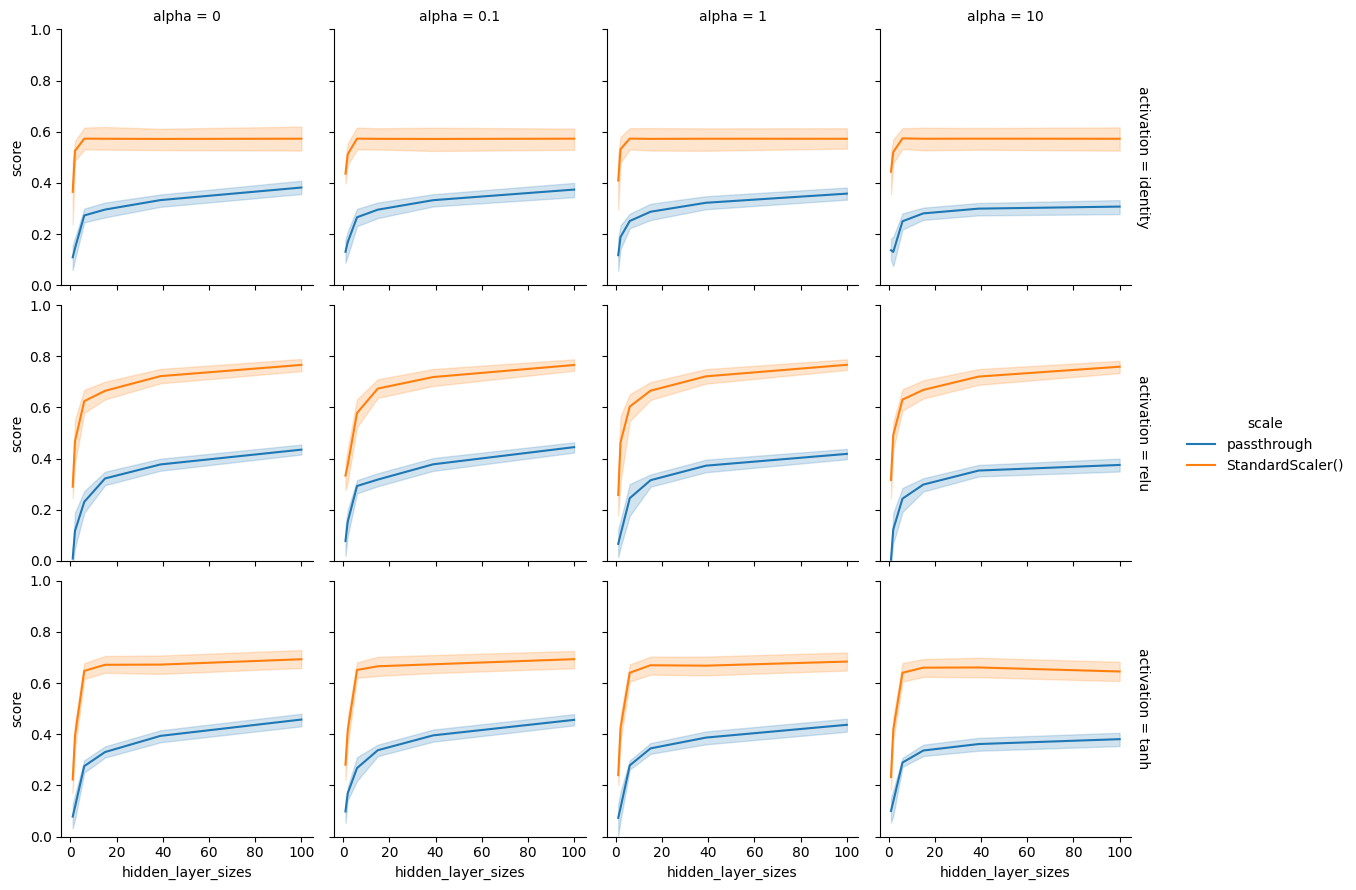

In [76]:
perf = pd.DataFrame(cv.cv_results_)
clean = cleanup_cv_results(perf)

g = sns.FacetGrid(clean, col='alpha', row='activation', hue='scale', margin_titles=True)
g.map(sns.lineplot, 'hidden_layer_sizes', 'score')
g.set(ylim=(0,1))
g.add_legend()

**<span style="color: #ce2227;">TASK 4: </span>** Based on your knowledge of $R^2$ performance, you should be able to determine which neural network configuration gave the best performance on this problem. With appropriate justification, identify which neural network performed best.

The network with an alpha value of 1, activation function of relu and around 100 size for the hidden layer as the R^2 performance was around 0.8, which means 80% of the variance of the model can be explained by the models inputs. Which means out of all the configurations this in moving the most in line with the index.

Finally, consider this ***OPTIONAL*** task:

**<span style="color: #ce2227;">TASK 5: <span>** Based on the results shown in the graph, briefly comment on what happes to the neural network behaviour when the activation argument is set to 'identity' (which equates to linear activation functions).

_WRITE YOUR ANSWER HERE_

## The End

You've reached the end of the lab. Be sure to save and upload your work to Blackboard before the due date. ***Assuming that there is time remaining in the lab, you should use this time to work on the first assignment.***